In [1]:
import streamsculptor
from streamsculptor import  potential
from streamsculptor import fields
from streamsculptor import JaxCoords as jc
import diffrax
from jax.scipy.stats import gaussian_kde
import jax
import equinox as eqx
jax.config.update("jax_enable_x64", True)


from gala.units import UnitSystem
from astropy import units as u
usys = UnitSystem(u.kpc, u.Myr, u.Msun, u.radian)
import jax.numpy as jnp


import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord

import gala.coordinates as gc

from functools import partial
from gala.units import galactic

import tqdm
#import scienceplots
import matplotlib as mpl
#plt.style.use('science')
mpl.rcParams['text.usetex'] = False ## We do not have LaTex on stellar HPC...
from astropy.constants import G as G_
#import tqdm
G_jax = jnp.array(G_.to(u.kpc**3 / (u.Msun * u.Myr**2)).value)

from scipy.interpolate import UnivariateSpline
#from scipy.integrate import cumtrapz

from jax import random
import seaborn as sns


2025-03-11 09:18:38.730026: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.5 which is older than the PTX compiler version 12.6.68. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
jax.devices()

[CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]

In [3]:
jax.default_device('CudaDevice(id=0)')

In [4]:
#Check that you're running on GPU
# Check that Jax works  on GPU - should print GPU
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


/tmp/ipykernel_2603312/2136833081.py:4: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print(xla_bridge.get_backend().platform)


In [5]:
#SP added for plotting
mpl.rcParams.update({'font.size': 20})
label_size = 20
mpl.rcParams['xtick.labelsize'] = 18#label_size 
mpl.rcParams['ytick.labelsize'] =18#label_size 


In [6]:
interp_func = jnp.load('general_nfw_interp.npy',allow_pickle=True).item()
@jax.jit
def generalized_nfw_potential(xyz, t, params):
    r = jnp.sqrt(jnp.sum(xyz**2)) 
    r_over_r_s = r/params['r_s']
    bracket = interp_func(r_over_r_s,params['gamma'],params['beta'])*(params['r_s']**2)
    return -4*jnp.pi*G_jax*bracket*params['rho0']


#params = dict(gamma=1.0,beta=3, r_s=10.0, rho0=1e7)

In [7]:
#use functions above to generate truth density, and then also bounds for 1 sigma for  inner and outer streams... 
# we have r param and then density from function
# then we input truth value for beta, gamma, rs. 
#Then we compute those same bounds for upper and lower sigma values for gamm, beta, rs for both outer, inner, curlicue 


#rho0_paperplot = np.log10(get_nfw_rho0(1e12,8.1497))
# params = dict(gamma=0.8853,beta=3.674, r_s=18.1497, rho0=10**rho0_paperplot)
# get_general_NFW_potential(params).potential(jnp.array([1.0,2.0,3.0]),0.0)
#generalized_nfw_potential(jnp.array([1.0,2.0,3.0]),0.0, params)

In [8]:
from streamsculptor.potential import CustomPotential
def get_general_NFW_potential(params):
    pot = lambda xyz, t: generalized_nfw_potential(xyz, t, params)
    return CustomPotential(potential_func=pot, units=usys)

In [9]:
params = dict(gamma=1.4,beta=3, r_s=10.0, rho0=1e7)
get_general_NFW_potential(params).potential(jnp.array([1.0,2.0,3.0]),0.0)

Array(-0.06174879, dtype=float64)

In [10]:
@jax.jit
def get_nfw_rho0(M,r_s):
    c_NFW = 15. # following https://arxiv.org/pdf/2211.04495
    denom = jnp.log(1. + c_NFW) - (c_NFW/(1+c_NFW))
    fac = 1./denom
    rho0 = (M/(4*jnp.pi*r_s**3))*fac
    return rho0
np.log10(get_nfw_rho0(3e12,22.))

np.float64(7.086986282014672)

In [11]:
# 

In [12]:
 #outer_stream_prog0 = dict(x_prog=x_center_outer1,y_prog=y_center_outer3,z_prog=y_center_outer1,speed = 0.1,vel_theta=theta_today,vel_phi=phi_today, log10_M_prog=8.4,
#                         log10_m_disk=jnp.log10(5e10), a_disk=3.0,b_disk=0.2,log10_m_halo=12.879588052300889,r_s=8.1497,gamma=0.8853,beta=3.674,
#                          t_age=2000., N_arm=4_000 )

In [13]:
from streamsculptor.potential import MiyamotoNagaiDisk
from streamsculptor import potential

In [ ]:
@partial(jax.jit,static_argnames=('pot','solver','n_stripping_times','max_steps','rtol','atol','dtmin'))
def gen_stream_vmapped_jacobi_stripping(pot=None, n_stripping_times=None, t0=None, t1=None, prog_w0=None, Msat=None, factor_min_Jacobi_Radius=2.0, seed_num=None, solver=diffrax.Dopri5(scan_kind='bounded'), kval_arr=1.0,max_steps=10_000,rtol=1e-7,atol=1e-7,dtmin=0.1, dense_times_factor=30):
    """
    This function is a wrapper for the gen_stream_vmapped function.
    Must supply the potential function (pot) and number of stripping times (n_stripping_times)
    The function will determine when the stripping times occur.
    We will only strip particles when the Jacobi radius is less than a factor of the minimum Jacobi radius.
    The factor is given by the argument: factor_min_Jacobi_Radius (default = 2.0)
    t0: starting time [Myr]
    t1: ending time [Myr] --> t1 > t0
    """

    # Integrator progenitor orbit, saving the trajectory at n_stripping_times evenly spaced times between t0 and t1
    save_times_orbit = jnp.linspace(t0, t1, n_stripping_times)
    prog_orb = pot.integrate_orbit(w0=prog_w0,              
                                   ts=save_times_orbit, 
                                   solver=solver, 
                                   max_steps=max_steps, 
                                   rtol=rtol, 
                                   atol=atol, 
                                   dtmin=dtmin)
    # Compute the Jacobi radius at each time step
    Jacobi_Radius_timeseries = jax.vmap(pot.tidalr,in_axes=(0,0,None,0))(prog_orb.ys[:,:3], prog_orb.ys[:,3:], Msat, save_times_orbit)
    #vcirc_timeseries = 


    # Interpolate the Jacobi radius to get a smooth function in time
    Jacobi_Radius_interp = interpax.Interpolator1D(save_times_orbit, Jacobi_Radius_timeseries, method='cubic2')

    # Determine the minimum Jacobi radius and set the threshold for stripping, evaluating over a dense set of times
    dense_times = jnp.linspace(t0, t1, n_stripping_times*dense_times_factor)

    Jacobi_Radius_eval = Jacobi_Radius_interp(dense_times)
    #min_Jacobi_Radius = jnp.min(Jacobi_Radius_eval)
    # Set the threshold for stripping to be a factor of the minimum Jacobi radius
    r_thresh =  factor_min_Jacobi_Radius #2 x the R from eq. 18 in Shen et al  2003, reading in from stream_gen


    # Determine the times when the Jacobi radius is less than the threshold
    # It should strip if Jacobi_Radius_eval < r_thresh 
    strip_bool = Jacobi_Radius_eval < r_thresh
    # indices of the times when the Jacobi radius is less than the threshold
    inds_arange = jnp.arange(len(strip_bool))
    # indicator variable: 1 when stripping occurs, 0 otherwise
    indicator = jnp.where(strip_bool==True, 1, 0)
    # probability of stripping is the indicator variable divided by the sum of the indicator variable 
    # The probaility is uniform when in the stripping window, and zero otherwise. So this is statistically
    # equivalent to uniform stripping times whenever the stripping condition is met.
    prob_strip = indicator/jnp.sum(indicator)
    key_strip = jax.random.PRNGKey(seed_num)
    # randomly sample the times when stripping occurs [number of samples: n_stripping_times], with probability given by prob_strip
    ind_tstrip = jax.random.choice(key=key_strip,a=inds_arange,replace=True, p=prob_strip, shape=(n_stripping_times,) )
    # Extract the stripping times. This is allowed, since we always extract n_stripping_times (static argument)
    tstrip_stream =  dense_times.at[ind_tstrip].get()
    # Sort the stripping times
    tstrip_stream = jnp.sort(tstrip_stream) ## ASSUMING ASCENDING TIME ORDER
    # Generate the stream, releasing two particles from L1 and L2 at tstrip_stream
    # Starting time must be t0 and ending time must be t1
    tstrip_stream = tstrip_stream.at[0].set(t0) 
    tstrip_stream = tstrip_stream.at[-1].set(t1)
    #tstrip_stream = jnp.unique(tstrip_stream) # remove duplicates, if any
    stream_lead, stream_trail = pot.gen_stream_vmapped( prog_w0=prog_w0, 
                            Msat=Msat,
                            ts=tstrip_stream,
                            seed_num=seed_num,
                            kval_arr=kval_arr,
                            max_steps=max_steps,
                            rtol=rtol,
                            atol=atol,
                            dtmin=dtmin
                            )

    return stream_lead[1:], stream_trail[1:], dict(prob_strip=prob_strip,dense_times=dense_times,tstrip_stream=tstrip_stream[1:-1], prog_orb=prog_orb,Jacobi_Radius_eval=Jacobi_Radius_eval)

In [15]:
import interpax


In [16]:
# #import jax
# jax.clear_backends()  # Clear JAX backends (helps reset GPU state)


In [ ]:
def get_potential(params):
    pot_disk =  MiyamotoNagaiDisk(m=params['m_disk'], a=params['a_disk'],
                                       b=params['b_disk'],units=usys)
    rho0 = get_nfw_rho0(params['M'],params['r_s'])
    
    pot_halo = get_general_NFW_potential(dict(rho0=rho0, gamma=params['gamma'], beta=params['beta'],
                                              r_s=params['r_s']))
    
    
    potential_list = [pot_disk,pot_halo]
    pot = potential.Potential_Combine(potential_list=potential_list,units=usys)
    return pot


    

@partial(jax.jit,static_argnums=(15,))
def gen_stream(x_prog=None, 
               y_prog=None, 
               z_prog=None, 
               log10_M_prog=None, 
               speed=None, 
               vel_theta=None, 
               vel_phi=None, 
               log10_m_disk=None, 
               a_disk=None,
               b_disk=None, 
               log10_m_halo=None, 
               r_s=None, 
               gamma=None, 
               beta=None, 
               t_age=None, 
               N_arm=None,
               offset=jnp.array([-40,0.0,140.0,0.0,0.0,0.0])):
    """
    x and z is sky plane, y is LOS
    xyz_prog is the progenitor position today in these coords
    speed is the total speed of the prog.
    vel_theta controls the spherical polar direction of the unit velocity vector [0,pi]
    vel_phi controls the azimuthal direction of the unit velocity vector [0,2pi]
    """
    params = {'m_disk':10**log10_m_disk, 'a_disk': a_disk, 'b_disk': b_disk, 'M': 10**log10_m_halo,
                          'r_s': r_s, 'gamma': gamma, 'beta':beta, 't_age':t_age}
    pot = get_potential(params)
    v_x_hat = jnp.sin(vel_theta)*jnp.cos(vel_phi)
    v_y_hat = jnp.cos(vel_theta) #SP moved
    v_z_hat = jnp.sin(vel_theta)*jnp.sin(vel_phi)
    velocity_today = jnp.array([v_x_hat, v_y_hat, v_z_hat])*speed
    

    pos_today = jnp.array([x_prog, y_prog, z_prog])
    w_today = jnp.hstack([pos_today, velocity_today]) #correct units of kpc/myr
   # print('vel today')
   # print(velocity_today)
    
    ts = jnp.linspace(-t_age,0,N_arm) #4_000


    w_init = pot.integrate_orbit(w0=w_today, t0=0.0, t1=-t_age, ts=jnp.array([-t_age]),
                                 solver=diffrax.Tsit5(),atol=1e-6, rtol=1e-6,dtmin=0.5,max_steps=20_000).ys[0]

   # pot.tidalr,in_axes=(0,0,None,0))

    #to plot v_circ
    simulated_pos = (jnp.vstack((jnp.linspace(0.1,200,600),0*jnp.linspace(0.1,200,600),0*jnp.linspace(0.1,200,600)))).T
    r_eval = simulated_pos[:,0]
    circ_vel = jax.vmap(pot.local_circular_velocity,in_axes=(0,None))(r_eval, 0.)  



#     r_eval_np = jnp.array(r_eval).block_until_ready()
#     circular_velocity_np = jnp.array(pot.local_circular_velocity(r_eval, 0)).block_until_ready()

#     plt.plot(r_eval_np, circular_velocity_np)
# #need t arg below
#    # plt.plot(np.array(r_eval), np.array(pot.local_circular_velocity(r_eval, 0)))

#     #plt.plot(r_eval, pot.local_circular_velocity(r_eval,0))
#     plt.yscale('log')
#     plt.xscale('log')
#     plt.show()

    ## Now generate a mock stream along the above orbit
    Msat = 10**log10_M_prog #progenitor mass
    seed = 4031

    # this below should be a function of Msat 
    # Prole 2021, U Sidney eq 6
    #Shen 2003, SDSS size mass relationship, eq. 15 extrapolated and eq 18 + table 1
    # See Shen 2003 Fig 11
    #late type table 1 
    gamma_re = 0.1
    alpha_re = 0.14
    M0 = 3.98*10**10
    beta_re  = 0.39
    r_e = gamma_re * Msat**alpha_re * (1 + Msat/M0)**(beta_re - alpha_re) #kpc
#    logr_e = 
#    factor_min_Jacobi_Radius =1.5
#### think about this below to not do this twice!`
    stream_lead, stream_trail, dict_out = gen_stream_vmapped_jacobi_stripping(pot=pot, 
                                    n_stripping_times=1_000, 
                                    t0=-t_age, 
                                    t1=0.0, 
                                    prog_w0= w_init, #this should not be today but they backwards integrated time... 
                                    Msat=Msat,
                                    factor_min_Jacobi_Radius= 2 * r_e, #if Jacobi_r(t) is within factor*Jaocbi_min, strip particles
                                    seed_num=seed)    

    #stream = jnp.vstack([lead_arm,trail_arm])
    stream = jnp.vstack([stream_lead,stream_trail])
    return dict_out, stream, r_e #dict(w_today=w_today, stream=stream, stripping_times=jnp.hstack([ts, ts]))


In [29]:
# #This is where we can generate our own stream, but we will use input data from your observations/simulations

# # dict_inp = dict(x_prog=78, y_prog=82., z_prog=0., log10_M_prog=7.0, speed=.16, vel_theta=.1, vel_phi=4.5,
# #                log10_m_disk=11.0, a_disk=3.0, b_disk=0.25, log10_m_halo=11.0, r_s=8.0, gamma=1.0, beta=3.0, 
# #                t_age=4_000, N_arm=1000)

# # SP adding these values for the truth below for the FIRE outer stream which we know from sims
# dict_inp= dict(x_prog=-68.33541927,y_prog=90.1126408 ,z_prog=24.78097,speed = 0.17979047160983772,vel_theta=theta_today,vel_phi=phi_today, log10_M_prog=8.5,
#                         log10_m_disk=jnp.log10(5e10), a_disk=3.0,b_disk=0.2,log10_m_halo=12.0,r_s=8.1497,gamma=0.8853,beta=3.674,
#                          t_age=2000., N_arm=4_000 )

# tst = gen_stream(**dict_inp)

In [30]:
# dict_inp["N_arm"] = 500 
# tst = gen_stream(**dict_inp)

In [38]:
# #tst['stream']
# plt.scatter(tst['stream'][:,0],tst['stream'][:,2],s=0.006,color='k')
# # plt.xlim([-100,100])
# plt.ylim([-100,100])


In [39]:
# #this is if we have generated our own stream, ignore for now. 

# outer_stream_prog2 = dict(x_prog=-40.0,
#                           y_prog=160.0,
#                           z_prog=150.0,
#                           speed=.4,
#                           vel_theta=1.5, 
#                           vel_phi=1.2,
#                           log10_M_prog=8.0,
#                           log10_m_disk=jnp.log10(5e10), 
#                           a_disk=3.0,b_disk=0.2,log10_m_halo=13.0,r_s=22.0,
#                           gamma=1.0,beta=3.,
#                           t_age=5_000.,
#                           N_arm=4_000) 

# outer_stream_dict = gen_stream(**outer_stream_prog2)

In [40]:
# outer_stream_dict

In [41]:
# plt.scatter(outer_stream_dict['stream'][:,0],outer_stream_dict['stream'][:,2],s=0.006,color='k')


In [42]:
# SP added

#Change this path to your path of the control point data if you want to read it in
data_path = "data/"
plot_path = "Figs/"

In [43]:
pos = np.load(data_path + 'm12m_streams_pos.npy')
vel = np.load(data_path + 'm12m_streams_vel.npy')


#these velow are rhe streams separated 
#outer: short straight stream
pos_outer= np.load(data_path + 'm12m_intact_prog_pos.npy')
vel_outer = np.load(data_path + 'm12m_intact_prog_vel.npy')


pos_inner = np.load(data_path + 'm12m_massive_stream_pos.npy')
vel_inner = np.load(data_path + 'm12m_massive_stream_vel.npy')


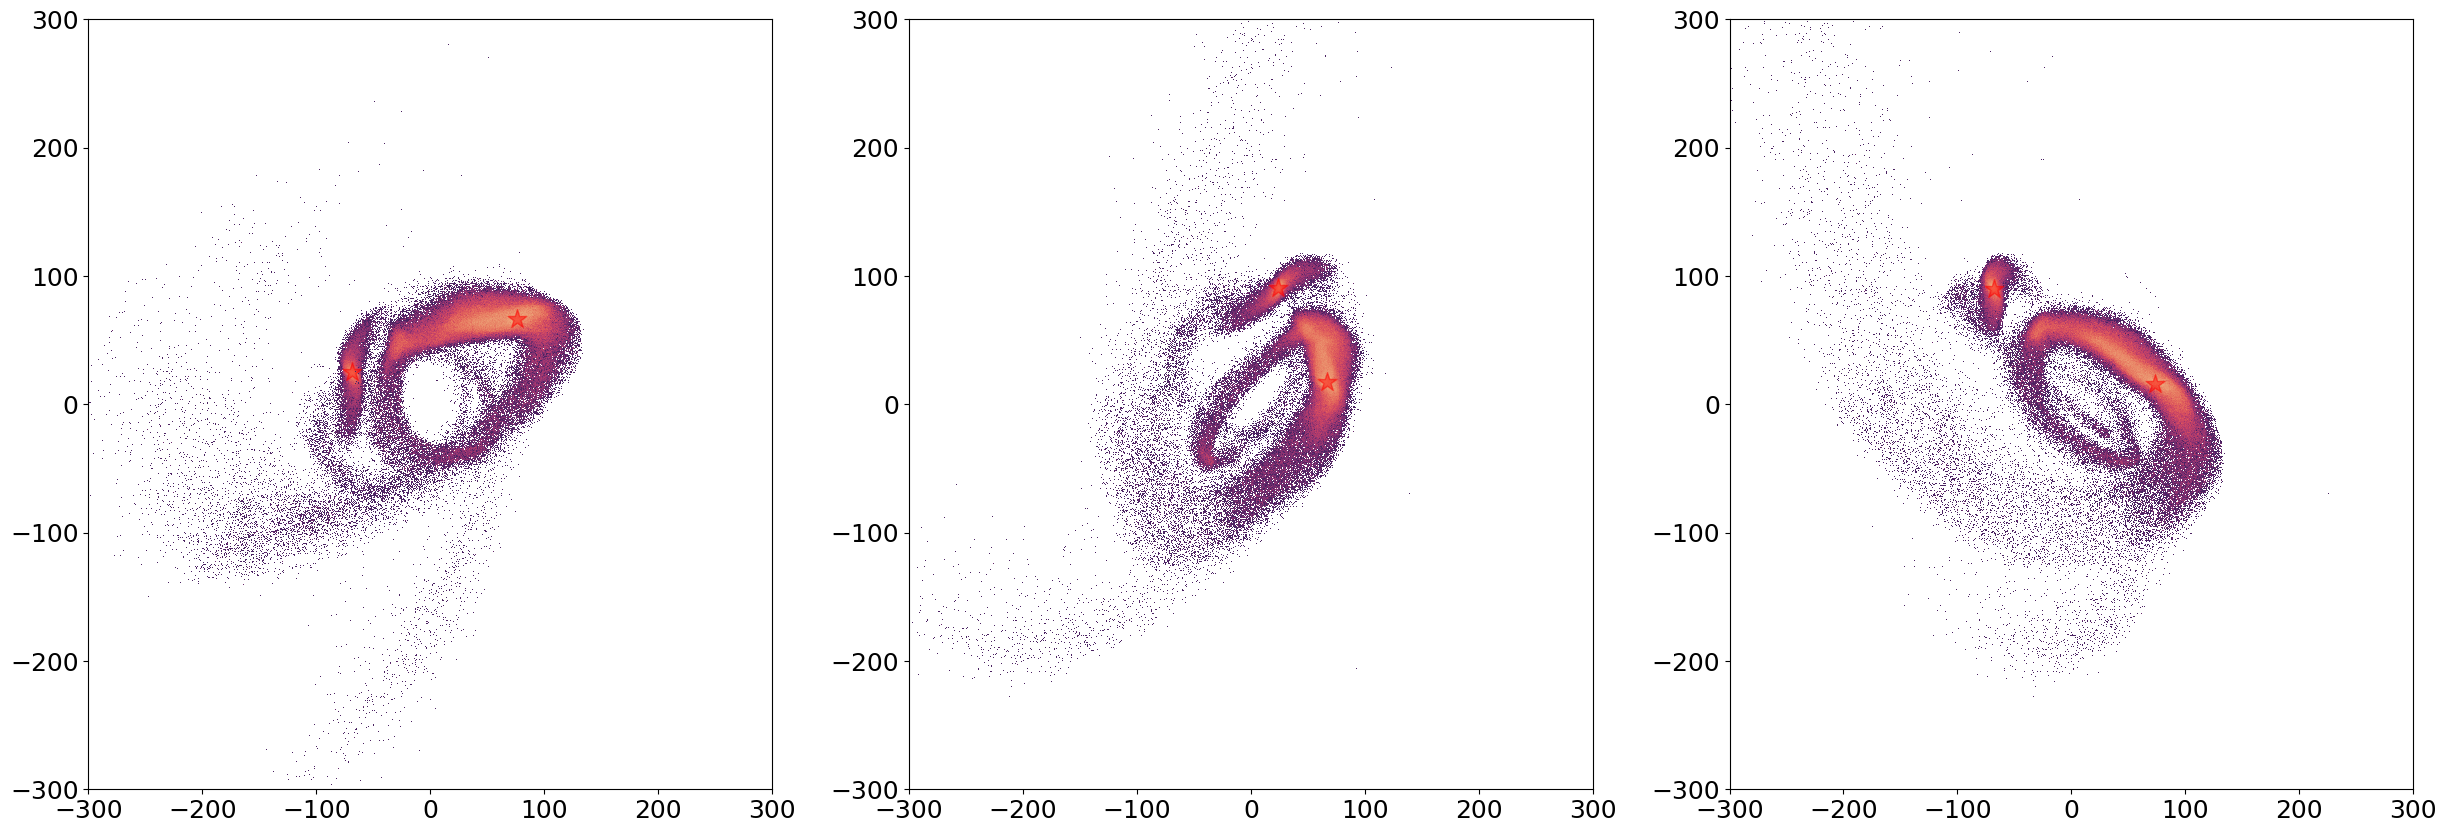

In [44]:
histcolor = sns.color_palette("flare_r", as_cmap=True)
#sns.color_palette("mako", as_cmap=True)#sns.cubehelix_palette(as_cmap=True)#sns.color_palette("rocket", as_cmap=True)

f, ax=plt.subplots(1,3, figsize=(30,10))

counts_1outer, xedges_1outer, yedges_1outer, im_1outer = ax[0].hist2d(pos_outer[:,0], pos_outer[:,1], cmap = histcolor, bins=np.linspace(-300,300,800), norm=LogNorm());
counts_2outer, xedges_2outer, yedges_2outer, im_2outer=  ax[1].hist2d(pos_outer[:,1], pos_outer[:,2], cmap = histcolor,bins=np.linspace(-300,300,800), norm=LogNorm());
counts_3outer, xedges_3outer, yedges_3outer, im_3outer = ax[2].hist2d(pos_outer[:,0], pos_outer[:,2], cmap = histcolor,bins=np.linspace(-300,300,800), norm=LogNorm());

#Now grab progenitors 
prog_outer1_index =  np.unravel_index(np.argmax(counts_1outer), counts_1outer.shape)
x_center_outer1 = 0.5 * (xedges_1outer[prog_outer1_index[0]] + xedges_1outer[prog_outer1_index[0] + 1])
y_center_outer1 = 0.5 * (yedges_1outer[prog_outer1_index[1]] + yedges_1outer[prog_outer1_index[1] + 1])

prog_outer2_index =  np.unravel_index(np.argmax(counts_2outer), counts_2outer.shape)
x_center_outer2 = 0.5 * (xedges_2outer[prog_outer2_index[0]] + xedges_2outer[prog_outer2_index[0] + 1])
y_center_outer2 = 0.5 * (yedges_2outer[prog_outer2_index[1]] + yedges_2outer[prog_outer2_index[1] + 1])

prog_outer3_index =  np.unravel_index(np.argmax(counts_3outer), counts_3outer.shape)
x_center_outer3 = 0.5 * (xedges_3outer[prog_outer3_index[0]] + xedges_3outer[prog_outer3_index[0] + 1])
y_center_outer3 = 0.5 * (yedges_3outer[prog_outer3_index[1]] + yedges_3outer[prog_outer3_index[1] + 1])

# Now plot progenitors
#print(prog_outer1_index,x_center_outer1,y_center_outer1 )
ax[0].scatter(x_center_outer1,y_center_outer1, marker='*', s=200, color='r', alpha=0.5)
ax[1].scatter(x_center_outer2,y_center_outer2, marker='*', s=200, color='r', alpha=0.5)
ax[2].scatter(x_center_outer3,y_center_outer3, marker='*', s=200, color='r', alpha=0.5)


counts_1inner, xedges_1inner, yedges_1inner, im_1inner = ax[0].hist2d(pos_inner[:,0], pos_inner[:,1],cmap = histcolor,bins=np.linspace(-300,300,800), norm=LogNorm());
counts_2inner, xedges_2inner, yedges_2inner, im_2inner = ax[1].hist2d(pos_inner[:,1], pos_inner[:,2],cmap = histcolor, bins=np.linspace(-300,300,800), norm=LogNorm());
counts_3inner, xedges_3inner, yedges_3inner, im_3inner = ax[2].hist2d(pos_inner[:,0], pos_inner[:,2],cmap = histcolor, bins=np.linspace(-300,300,800), norm=LogNorm());

#Now grab progenitors 
prog_inner1_index =  np.unravel_index(np.argmax(counts_1inner), counts_1inner.shape)
x_center_inner1 = 0.5 * (xedges_1inner[prog_inner1_index[0]] + xedges_1inner[prog_inner1_index[0] + 1])
y_center_inner1 = 0.5 * (yedges_1inner[prog_inner1_index[1]] + yedges_1inner[prog_inner1_index[1] + 1])


prog_inner2_index =  np.unravel_index(np.argmax(counts_2inner), counts_2inner.shape)
x_center_inner2 = 0.5 * (xedges_2inner[prog_inner2_index[0]] + xedges_2inner[prog_inner2_index[0] + 1])
y_center_inner2 = 0.5 * (yedges_2inner[prog_inner2_index[1]] + yedges_2inner[prog_inner2_index[1] + 1])

prog_inner3_index =  np.unravel_index(np.argmax(counts_3inner), counts_3inner.shape)
x_center_inner3 = 0.5 * (xedges_3inner[prog_inner3_index[0]] + xedges_3inner[prog_inner3_index[0] + 1])
y_center_inner3 = 0.5 * (yedges_3inner[prog_inner3_index[1]] + yedges_3inner[prog_inner3_index[1] + 1])


# Now plot progenitors
#print(prog_outer1_index,x_center_outer1,y_center_outer1 )
ax[0].scatter(x_center_inner1,y_center_inner1, marker='*', s=200, color='r', alpha=0.5)
ax[1].scatter(x_center_inner2,y_center_inner2, marker='*', s=200, color='r', alpha=0.5)
ax[2].scatter(x_center_inner3,y_center_inner3, marker='*', s=200, color='r', alpha=0.5)




In [45]:
#SP ## Now find vrad for the velocities for each of the 6 progenitors, 2 per projection 

bins=np.linspace(-300,300,800)
# Create a 2D histogram to bin the data

####################
H, xedges, yedges = np.histogram2d(pos_outer[:, 0], pos_outer[:, 1], bins=[bins, bins])
binned_velocities_o1 = np.zeros(H.shape)

for i in range(len(pos_outer)):
    # Find the bin index for each position
    x_bin = np.digitize(pos_outer[i, 0], bins) - 1  # -1 for 0-based index
    y_bin = np.digitize(pos_outer[i, 1], bins) - 1  # -1 for 0-based index
    
    if 0 <= x_bin < binned_velocities_o1.shape[0] and 0 <= y_bin < binned_velocities_o1.shape[1]:
        binned_velocities_o1[x_bin, y_bin] += vel_outer[i, 2]

# Normalize the binned velocities by the counts (optional)
for i in range(binned_velocities_o1.shape[0]):
    for j in range(binned_velocities_o1.shape[1]):
        count = H[i, j]
        if count > 0:
            binned_velocities_o1[i, j] /= count


###################
H, xedges, yedges = np.histogram2d(pos_outer[:, 1], pos_outer[:, 2], bins=[bins, bins])
binned_velocities_o2 = np.zeros(H.shape)

for i in range(len(pos_outer)):
    # Find the bin index for each position
    x_bin = np.digitize(pos_outer[i, 1], bins) - 1  # -1 for 0-based index
    y_bin = np.digitize(pos_outer[i, 2], bins) - 1  # -1 for 0-based index
    
    if 0 <= x_bin < binned_velocities_o2.shape[0] and 0 <= y_bin < binned_velocities_o2.shape[1]:
        binned_velocities_o2[x_bin, y_bin] += vel_outer[i, 0]

# Normalize the binned velocities by the counts (optional)
for i in range(binned_velocities_o1.shape[0]):
    for j in range(binned_velocities_o2.shape[1]):
        count = H[i, j]
        if count > 0:
            binned_velocities_o2[i, j] /= count


###################
H, xedges, yedges = np.histogram2d(pos_outer[:, 0], pos_outer[:, 2], bins=[bins, bins])
binned_velocities_o3 = np.zeros(H.shape)

for i in range(len(pos_outer)):
    # Find the bin index for each position
    x_bin = np.digitize(pos_outer[i, 0], bins) - 1  # -1 for 0-based index
    y_bin = np.digitize(pos_outer[i, 2], bins) - 1  # -1 for 0-based index
    
    if 0 <= x_bin < binned_velocities_o3.shape[0] and 0 <= y_bin < binned_velocities_o3.shape[1]:
        binned_velocities_o3[x_bin, y_bin] += vel_outer[i, 1]

# Normalize the binned velocities by the counts (optional)
for i in range(binned_velocities_o3.shape[0]):
    for j in range(binned_velocities_o3.shape[1]):
        count = H[i, j]
        if count > 0:
            binned_velocities_o3[i, j] /= count



############################

####################
H, xedges, yedges = np.histogram2d(pos_inner[:, 0], pos_inner[:, 1], bins=[bins, bins])
binned_velocities_i1 = np.zeros(H.shape)

for i in range(len(pos_inner)):
    # Find the bin index for each position
    x_bin = np.digitize(pos_inner[i, 0], bins) - 1  # -1 for 0-based index
    y_bin = np.digitize(pos_inner[i, 1], bins) - 1  # -1 for 0-based index
    
    if 0 <= x_bin < binned_velocities_i1.shape[0] and 0 <= y_bin < binned_velocities_i1.shape[1]:
        binned_velocities_i1[x_bin, y_bin] += vel_inner[i, 2]

# Normalize the binned velocities by the counts (optional)
for i in range(binned_velocities_i1.shape[0]):
    for j in range(binned_velocities_i1.shape[1]):
        count = H[i, j]
        if count > 0:
            binned_velocities_i1[i, j] /= count


###################
H, xedges, yedges = np.histogram2d(pos_inner[:, 1], pos_inner[:, 2], bins=[bins, bins])
binned_velocities_i2 = np.zeros(H.shape)

for i in range(len(pos_inner)):
    # Find the bin index for each position
    x_bin = np.digitize(pos_inner[i, 1], bins) - 1  # -1 for 0-based index
    y_bin = np.digitize(pos_inner[i, 2], bins) - 1  # -1 for 0-based index
    
    if 0 <= x_bin < binned_velocities_i2.shape[0] and 0 <= y_bin < binned_velocities_i2.shape[1]:
        binned_velocities_i2[x_bin, y_bin] += vel_inner[i, 0]

# Normalize the binned velocities by the counts (optional)
for i in range(binned_velocities_i1.shape[0]):
    for j in range(binned_velocities_i2.shape[1]):
        count = H[i, j]
        if count > 0:
            binned_velocities_i2[i, j] /= count


###################
H, xedges, yedges = np.histogram2d(pos_inner[:, 0], pos_inner[:, 2], bins=[bins, bins])
binned_velocities_i3 = np.zeros(H.shape)

for i in range(len(pos_inner)):
    # Find the bin index for each position
    x_bin = np.digitize(pos_inner[i, 0], bins) - 1  # -1 for 0-based index
    y_bin = np.digitize(pos_inner[i, 2], bins) - 1  # -1 for 0-based index
    
    if 0 <= x_bin < binned_velocities_i3.shape[0] and 0 <= y_bin < binned_velocities_i3.shape[1]:
        binned_velocities_i3[x_bin, y_bin] += vel_inner[i, 1]

# Normalize the binned velocities by the counts (optional)
for i in range(binned_velocities_i3.shape[0]):
    for j in range(binned_velocities_i3.shape[1]):
        count = H[i, j]
        if count > 0:
            binned_velocities_i3[i, j] /= count


# The resulting shape should be (799, 799)
#print(binned_velocities_o1.shape)  # Should print (799, 799)

#binned_velocities[prog_outer1_index]

In [46]:
#SP# Now make histograms with red points for new methods 
#  #from data make histogram of stream
#thresh: how many particles need to be in the bin 

def gen_stream_hist(stream_dim1,stream_dim2,thresh,xlin,zlin):
    """On sky x an z, xlin, zlin defines bin in each dimension"""
    H  = jnp.histogram2d(stream_dim1,stream_dim2,bins=(xlin,zlin))
    hist2d = H[0]
    #only keep things above the threshold
    masked_hist = jnp.where(hist2d>thresh,1.0,0.0)
    xinds, zinds = jnp.where(masked_hist == 1.)
    
    #even if only one star in a bin, wherever hist2 is grater than threshold, then use that
    # value otherwise zero and then normalize it 
    weights_of_pts = jnp.where(hist2d>thresh,hist2d,0.0)
    weights_of_pts = weights_of_pts/weights_of_pts.sum()
    
    #dx_over_2 = (xlin[2] - xlin[1])/2
    #dz_over_2 =  (zlin[2] - zlin[1])/2
    # Compute bin centers along both axes
    x_centers = 0.5 * (xlin[:-1] + xlin[1:])
    z_centers = 0.5 * (zlin[:-1] + zlin[1:])
    
    #spits out histogram (nxn grid dim of zlin zlin, value of histogram, midpoints)
    #indexed so also get coordinates of histogram points
    return masked_hist.T, weights_of_pts[xinds,zinds], x_centers[xinds], z_centers[zinds]#xlin[xinds] + dx_over_2, zlin[zinds] + dz_over_2

xlin_inner = jnp.linspace(-200,200,80)
zlin_inner = jnp.linspace(-200,200,80)

xlin_outer = jnp.linspace(-200,200,80)
zlin_outer = jnp.linspace(-200,200,80)
#for image you would just choose control poibts 
#for imaging wouldn't have the histogram step, just step of points (red)
#for image data just select out pixels where you are above a threshold, don't need histogram step
#the red are the datapoints we evaluate over

#for plot
H_proj1, weights, xpts, zpts = gen_stream_hist(pos[:,0],pos[:,1],100,xlin_inner,zlin_inner)
H_proj2, weights, xpts2, zpts2 = gen_stream_hist(pos[:,1],pos[:,2],100,xlin_inner,zlin_inner)
H_proj3, weights, xpts3, zpts3 = gen_stream_hist(pos[:,0],pos[:,2],100,xlin_inner,zlin_inner)



# for method 
#thresh = 200
H_proj1_inner, weights_inner, xpts_inner, zpts_inner = gen_stream_hist(pos_inner[:,0],pos_inner[:,1],100,xlin_inner,zlin_inner)
H_proj1_outer, weights_outer, xpts_outer, zpts_outer = gen_stream_hist(pos_outer[:,0],pos_outer[:,1],100,xlin_inner,zlin_inner)

H_proj2_inner, weights_inner2, xpts_inner2, zpts_inner2 = gen_stream_hist(pos_inner[:,1], pos_inner[:,2],100,xlin_inner,zlin_inner)
H_proj2_outer, weights_outer2, xpts_outer2, zpts_outer2 = gen_stream_hist(pos[:,1], pos[:,2],100,xlin_inner,zlin_inner)

H_proj3_inner, weights_inner3, xpts_inner3, zpts_inner3 = gen_stream_hist(pos_inner[:,0], pos_inner[:,2],100,xlin_inner,zlin_inner)
H_proj3_outer, weights_outer3, xpts_outer3, zpts_outer3 = gen_stream_hist(pos_outer[:,0], pos_outer[:,2],100,xlin_inner,zlin_inner)





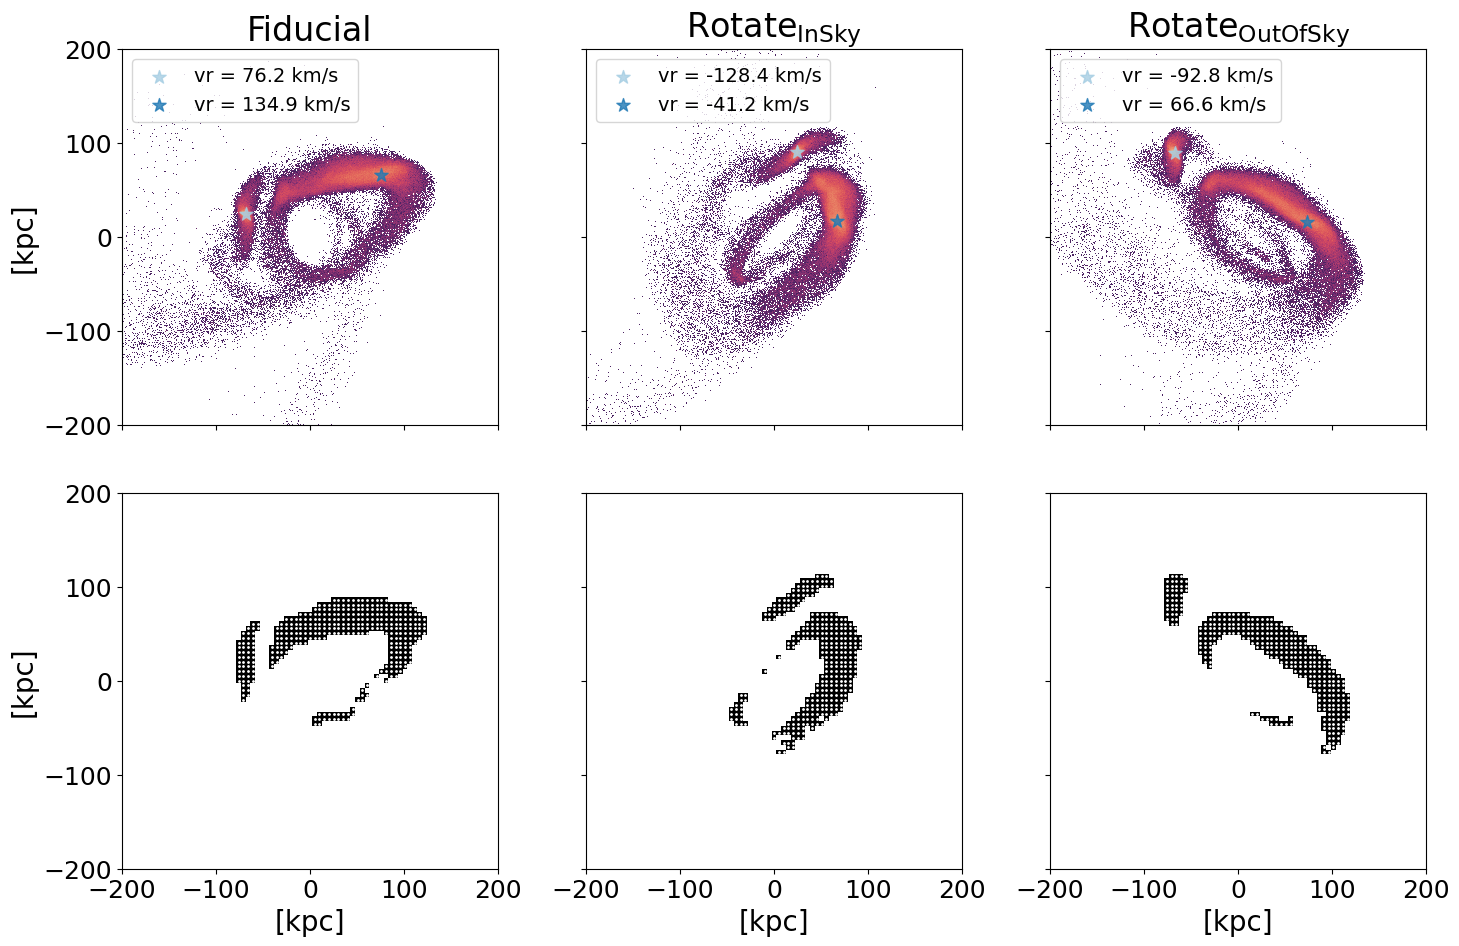

In [47]:
#SP check my input data points

color_prog= sns.color_palette("Paired")
dat = jnp.vstack([xpts, zpts]).T
dat2 = jnp.vstack([xpts2, zpts2]).T
dat3 = jnp.vstack([xpts3, zpts3]).T


#I need these inner outer distinctions for running the method on one stream at a time
# for plotting i can use the combined dat files instead above. 
dat_inner = jnp.vstack([xpts_inner, zpts_inner]).T
dat_inner2 = jnp.vstack([xpts_inner2, zpts_inner2]).T
dat_inner3 = jnp.vstack([xpts_inner3, zpts_inner3]).T

dat_outer = jnp.vstack([xpts_outer, zpts_outer]).T
dat_outer2 = jnp.vstack([xpts_outer2, zpts_outer2]).T
dat_outer3 = jnp.vstack([xpts_outer3, zpts_outer3]).T
#dat_outer = jnp.vstack([xpts_outer, zpts_outer]).T


f, ax=plt.subplots(2,3, figsize=(15,10), sharex = True, sharey=True)
ax[0,0].set_title('Fiducial')#Projection 1')
ax[0,1].set_title(r'Rotate$_{\rm InSky}$')
ax[0,2].set_title(r'Rotate$_{\rm OutOfSky}$')

ax[0,0].hist2d(pos[:,0], pos[:,1], bins=np.linspace(-300,300,800),  cmap = histcolor,norm=LogNorm());
ax[0,1].hist2d(pos[:,1], pos[:,2], bins=np.linspace(-300,300,800), cmap = histcolor, norm=LogNorm());
ax[0,2].hist2d(pos[:,0], pos[:,2], bins=np.linspace(-300,300,800), cmap = histcolor, norm=LogNorm());


# Now plot progenitors

#radial velocities 
ax[0,0].scatter(x_center_outer1,y_center_outer1, marker='*', s=100, color=color_prog[0], alpha=0.8, label ='vr = ' + str(np.round(binned_velocities_o1[prog_outer1_index],1)) + ' km/s')
ax[0,1].scatter(x_center_outer2,y_center_outer2, marker='*', s=100, color=color_prog[0], alpha=0.8, label ='vr = ' + str(np.round(binned_velocities_o2[prog_outer2_index],1)) + ' km/s')
ax[0,2].scatter(x_center_outer3,y_center_outer3, marker='*', s=100, color=color_prog[0], alpha=0.8, label ='vr = ' + str(np.round(binned_velocities_o3[prog_outer3_index],1)) + ' km/s')

ax[0,0].scatter(x_center_inner1,y_center_inner1, marker='*', s=100, color=color_prog[1], alpha=0.8,  label ='vr = ' + str(np.round(binned_velocities_i1[prog_inner1_index],1)) + ' km/s')
ax[0,1].scatter(x_center_inner2,y_center_inner2, marker='*', s=100, color=color_prog[1], alpha=0.8, label ='vr = ' + str(np.round(binned_velocities_i2[prog_inner2_index],1)) + ' km/s')
ax[0,2].scatter(x_center_inner3,y_center_inner3, marker='*', s=100, color=color_prog[1], alpha=0.8, label ='vr = ' + str(np.round(binned_velocities_i3[prog_inner3_index],1)) + ' km/s')



ax[0,0].set_xlim([-200,200])
ax[0,0].set_ylim([-200,200])
ax[0,0].set_ylabel('[kpc]')
ax[0,0].set_aspect('equal')
ax[0,0].legend(loc='upper left', fontsize=14)

ax[0,1].set_aspect('equal')
ax[0,1].set_xlim([-200,200])
ax[0,1].set_ylim([-200,200])
ax[0,1].legend(loc='upper left', fontsize=14)

ax[0,2].set_xlim([-200,200])
ax[0,2].set_ylim([-200,200])
ax[0,2].set_aspect('equal')
ax[0,2].legend(loc='upper left', fontsize=14)



ax[1,0].pcolormesh(xlin_inner,zlin_inner,H_proj1,cmap='binary')
ax[1,0].scatter(dat[:,0],dat[:,1],color='w',s=1)


ax[1,0].set_aspect('equal')
#ax[1].set_aspect('equal')
ax[1,0].set_xlabel('[kpc]')
ax[1,0].set_ylabel('[kpc]')

ax[1,1].pcolormesh(xlin_inner,zlin_inner,H_proj2,cmap='binary')
ax[1,1].scatter(dat2[:,0],dat2[:,1],color='w',s=1)

ax[1,1].set_aspect('equal')
ax[1,1].set_xlabel('[kpc]')


ax[1,2].pcolormesh(xlin_inner,zlin_inner,H_proj3,cmap='binary')
ax[1,2].scatter(dat3[:,0],dat3[:,1],color='w',s=1)
ax[1,2].set_aspect('equal')
ax[1,2].set_xlabel('[kpc]')

f.tight_layout()

#f.savefig(plot_path+'projections.png')

In [48]:
#we made histogram above, so I don't need this

# def gen_stream_hist(stream_dim1,stream_dim2,thresh,xlin,zlin):
#     H  = jnp.histogram2d(stream_dim1,stream_dim2,bins=(xlin,zlin))
#     hist2d = H[0]
#     masked_hist = jnp.where(hist2d>thresh,1.0,0.0)
#     xinds, zinds = jnp.where(masked_hist == 1.)
    
#     weights_of_pts = jnp.where(hist2d>thresh,hist2d,0.0)
#     weights_of_pts = weights_of_pts/weights_of_pts.sum()
    
#     #dx_over_2 = (xlin[2] - xlin[1])/2
#     #dz_over_2 =  (zlin[2] - zlin[1])/2
#     # Compute bin centers along both axes
#     x_centers = 0.5 * (xlin[:-1] + xlin[1:])
#     z_centers = 0.5 * (zlin[:-1] + zlin[1:])
    
#     return masked_hist.T, weights_of_pts[xinds,zinds], x_centers[xinds], z_centers[zinds]#xlin[xinds] + dx_over_2, zlin[zinds] + dz_over_2
    


# xlin_outer = jnp.linspace(-100,80,60) 
# zlin_outer = jnp.linspace(50,180,61)
# H_outer, weights_outer, xpts_outer, zpts_outer = gen_stream_hist(outer_stream_dict['stream'][:,0],
#                                                                  outer_stream_dict['stream'][:,2],
#                                                                  4.,
#                                                                  xlin_outer,
#                                                                  zlin_outer)


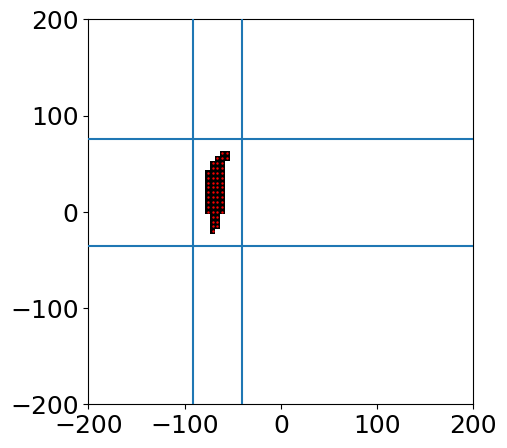

In [49]:
#SP now looking at the outer stream only, so selecting H_proj1_out and xlin_outer,zlin_outer
#from now on the coordinates are correct in x,z as plane of sky

#dat_inner = jnp.vstack([xpts_inner, zpts_inner]).T
# drawing bounds to not penalize stream from being longer than control points dictate 
pad = 15. 
xbounds = jnp.array([xpts_outer.min()-pad, xpts_outer.max()+pad])
zbounds = jnp.array([zpts_outer.min()-pad, zpts_outer.max()+pad])


dat_outer = jnp.vstack([xpts_outer, zpts_outer]).T


fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,5)

ax.pcolormesh(xlin_outer,zlin_outer,H_proj1_outer,cmap='binary')
ax.scatter(dat_outer[:,0],dat_outer[:,1],color='r',s=.5)
#ax.scatter(outer_stream_dict['stream'][:,0],outer_stream_dict['stream'][:,2],s=0.06,color='g',zorder=3,)

ax.set_xlim(xlin_outer.min(), xlin_outer.max())
ax.set_ylim(zlin_outer.min(),zlin_outer.max())


ax.vlines(xbounds[0],-1e5,1e5,zorder=50)
ax.vlines(xbounds[1],-1e5,1e5,zorder=50)
ax.hlines(zbounds[0],-1e5,1e5,zorder=50)
ax.hlines(zbounds[1],-1e5,1e5,zorder=50)

ax.set_aspect('equal')




In [50]:
#SP now we need to make kde for method to compare to, KDE from control points

@jax.jit
def regional_weight_func(xloc, zloc, xbounds, zbounds,scale_fac=.5):
    arg=( (xloc - jnp.mean(xbounds)) / (scale_fac*(xbounds[1]-xbounds[0])) )**2 + ( (zloc - jnp.mean(zbounds)) / (scale_fac*(zbounds[1]-zbounds[0])) )**2
    return jnp.exp(-0.5*arg)
   
regional_weight_func(-29.,120.,xbounds,zbounds)

mapped_weight_func = jax.vmap(regional_weight_func,in_axes=(0,0,None,None,None))

In [51]:
jax.jacfwd(regional_weight_func,argnums=(0,1,))(21.,120.,xbounds,zbounds,.5)

(Array(-6.98891488e-05, dtype=float64), Array(-1.64534506e-05, dtype=float64))

In [52]:
@jax.jit
def kde_fit_and_eval(x_stream, z_stream, x_eval, z_eval,bw=.1):
    in_bounds = (x_stream > xbounds[0]) & (x_stream < xbounds[1]) & (z_stream > zbounds[0]) & (z_stream < zbounds[1])
    weights_init = jnp.where(in_bounds, 1.0, 0.0)
    inp = jnp.vstack([x_stream, z_stream])
    inp_eval = jnp.vstack([x_eval, z_eval])
    #bw = .1 #was .15
    denom = gaussian_kde(inp,bw_method=bw,weights=weights_init).pdf(inp)
    weights = jnp.where(in_bounds, 1./denom, 0.0)
    weights = weights/weights.sum()
    
    pdf = gaussian_kde(inp,bw_method=bw,weights=weights).pdf(inp_eval)
    return pdf
    
    
    
@jax.jit
def kde_fit_and_log_eval(x_stream, z_stream, x_eval, z_eval,bw=.1): #.1
    in_bounds = (x_stream > xbounds[0]) & (x_stream < xbounds[1]) & (z_stream > zbounds[0]) & (z_stream < zbounds[1])
    weights_init = jnp.where(in_bounds, 1.0, 0.0)
    inp = jnp.vstack([x_stream, z_stream])
    inp_eval = jnp.vstack([x_eval, z_eval])
    #bw = .1 #was .15
    denom = gaussian_kde(inp,bw_method=bw,weights=weights_init).pdf(inp)
    weights = jnp.where(in_bounds, 1./denom, 0.0)
    weights = weights/weights.sum()
    logpdf_vals =  gaussian_kde(inp,bw_method=bw,weights=weights).logpdf(inp_eval)
    return logpdf_vals#jnp.where(jnp.isnan(logpdf_vals), jnp.inf, logpdf_vals)

    
    

In [53]:
X, Z = jnp.meshgrid(xlin_outer,zlin_outer)
x_eval, z_eval = X.flatten(), Z.flatten()

#SP below is from Jake's stream model, which we don't have in the case of FIRE or data
#pdf_out = kde_fit_and_eval(outer_stream_dict['stream'][:,0],outer_stream_dict['stream'][:,2], x_eval, z_eval, )



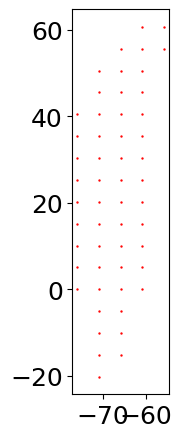

In [54]:
#SP in Jake's case he looks at the pdf of the generated stream.. I don't have a generated stream, but maybe I can skip that step?

fig, ax =  plt.subplots( 1 , 1 )
fig.set_size_inches(8,5)
#ax.pcolormesh(X, Z, pdf_out.reshape(X.shape))
ax.scatter(dat_outer[:,0],dat_outer[:,1],color='r',s=.5)  
ax.set_aspect('equal')


In [55]:
# Sp below are the true params for the corner plot
# To find true params in correct units for cornerplot:
#Pos today 

pos_today_true = jnp.array([x_center_outer1, y_center_outer3, y_center_outer1])
print('pos_today [x, y (los), z]')
print(pos_today_true)
print('')
#vel today
vx_today =np.round(binned_velocities_o1[prog_outer1_index],1)
vy_today = np.round(binned_velocities_o3[prog_outer3_index],1)
vz_today = np.round(binned_velocities_o2[prog_outer2_index],1)
vel_today =  jnp.array([vx_today, vy_today, vz_today])
print('vel_today  [vx, vlos, vz]')
print(vel_today)
print('')
v_mag = (vx_today**2 + vy_today**2 + vz_today**2)**0.5
print('v_mag')
print(v_mag)
print('')
vx_hat_today = vx_today / v_mag
vy_hat_today = vy_today / v_mag
vz_hat_today = vz_today / v_mag
v_hat_today = jnp.array([vx_hat_today , vy_hat_today , vz_hat_today ])
print('v_hat')
print(v_hat_today)
print('')
speed = v_mag*(u.km/u.s).to(u.kpc/u.Myr)
print('speed')
print(speed)
print('')
#sanity check that below is same as vz_hat
#jnp.sqrt(1.0 - vx_hat**2 -vy_hat**2)*pm

theta_today = jnp.arccos(vy_hat_today) #this should be our perpendicular to plane angle! y is here los. 
phi_today_test = jnp.arctan2(vz_today, vx_today) #between -pi to pi. 
#  Shift the range to 0 <= phi < 2*pi (by adding pi)
phi_today_shifted = phi_today_test + jnp.pi
#  Ensure phi is within 0 <= phi < 2*pi (by taking modulo 2*pi)
phi_today = jnp.mod(phi_today_shifted, 2 * jnp.pi)

#if phi_today < 0:
 #   phi_today = phi_today + 2*jnp.pi
print('phi,theta')
print(phi_today, theta_today )
#also need to find phi, theta of today...



pos_today [x, y (los), z]
[-68.33541927  90.1126408   24.78097622]

vel_today  [vx, vlos, vz]
[  76.2  -92.8 -128.4]

v_mag
175.79772467242006

v_hat
[ 0.43345271 -0.52787941 -0.73038488]

speed
0.17979047160983772

phi,theta
2.106391605359085 2.1268981435067404


## Plot stream from present day true fire params

In [90]:
# SP adding these values for the truth below for the FIRE outer stream which we know from sims
outer_stream_prog0 = dict(x_prog=x_center_outer1,y_prog=y_center_outer3,z_prog=y_center_outer1,speed = speed,vel_theta=theta_today,vel_phi=phi_today, log10_M_prog=8.5,
                        log10_m_disk=jnp.log10(1.3e11), a_disk=3.0,b_disk=0.2,log10_m_halo=12.72,r_s=8.1497,gamma=0.8853,beta=3.674,
                         t_age=1000., N_arm=4_000 )



# outer_stream_prog0 = dict(x_prog=-40.0,
#                           y_prog=160.0,
#                           z_prog=150.0,
#                           speed=.4,
#                           vel_theta=1.5, 
#                           vel_phi=1.2,
#                           log10_M_prog=8.0,
#                           log10_m_disk=jnp.log10(5e10), 
#                           a_disk=3.0,b_disk=0.2,log10_m_halo=13.0,r_s=22.0,
#                           gamma=1.0,beta=3.,
#                           t_age=5_000.,
#                           N_arm=4_000) 

In [91]:
jnp.arange(1)

Array([0], dtype=int64)

In [92]:
dict_out, stream,r_e = gen_stream(**outer_stream_prog0)

In [ ]:
#dict_out1, stream1, r_e1 = gen_stream(**outer_stream_prog1)
#plt.plot(r_eval, vcirc)

In [94]:

prog_orb = dict_out['prog_orb']
tstrip_stream = dict_out['tstrip_stream']

r_orb = jnp.sqrt(jnp.sum(prog_orb.ys[:,:3]**2,axis=1))

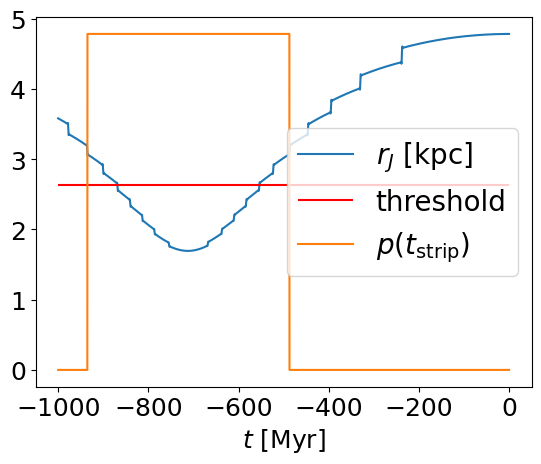

In [95]:
#Need threshold to be input or fixed...
#factor_min_Jacobi_Radius = 2.5
plt.plot(dict_out['dense_times'],dict_out['Jacobi_Radius_eval'],label=r'$r_J$ [kpc]')
plt.hlines(dict_out['Jacobi_Radius_eval'].min()*r_e,dict_out['dense_times'].min(),0,label='threshold',color='r')

#plt.plot(dict_out['dense_times'],dict_out['prob_strip']/(dict_out['prob_strip'].max())*dict_out['Jacobi_Radius_eval'].max(),label=r'$p(t_{\rm strip})$')
plt.plot(dict_out['dense_times'],dict_out['prob_strip']/(dict_out['prob_strip'].max())*dict_out['Jacobi_Radius_eval'].max(),label=r'$p(t_{\rm strip})$')
plt.xlabel(r'$t$ [Myr]',fontsize=18)
plt.legend()

Text(0, 0.5, '$r_{\\rm orb}$ [kpc]')

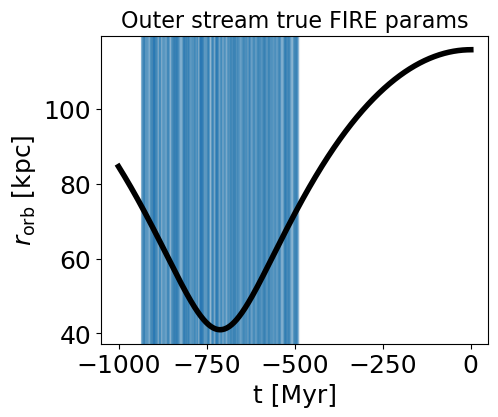

In [96]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(5,4)
ax.plot(prog_orb.ts, r_orb,zorder=5,color='k',lw=4,)
for i in range(len(tstrip_stream)-1):
    ax.axvline(x=tstrip_stream[i], ymin=0, ymax=1.,color='tab:blue', linestyle='-',alpha=0.1)

plt.title('Outer stream true FIRE params', fontsize=16)
ax.set_xlabel('t [Myr]',fontsize=18)
ax.set_ylabel(r'$r_{\rm orb}$ [kpc]',fontsize=18)
##plt.savefig('r_orb_t_and_strip.pdf')

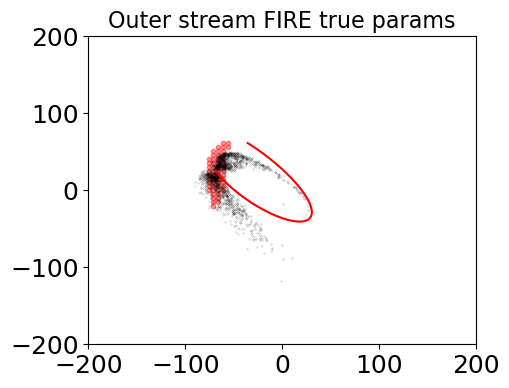

In [97]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(5,4)
#fig.set_title('From FIRE true params')
ax.scatter(stream[:,0], stream[:,2],zorder=5,color='k',s=0.05, alpha=0.4)
ax.plot(prog_orb.ys[:,0], prog_orb.ys[:,2],zorder=5,color='r')#
plt.xlim([-200,200])
plt.title('Outer stream FIRE true params', fontsize=16)
plt.ylim([-200,200])
plt.scatter(dat_outer[:,0], dat_outer[:,2], s=10, alpha = 0.4, color='red')# , label='[vx, vy_los, vz] =  '+ str(np.round(velocity_today*(u.kpc/u.Myr).to(u.km/u.s),2) )+ ' km/s')


In [98]:
# plt.figure(figsize=(7,7))
# plt.title('Outer', fontsize=16)
# plt.scatter(stream_dict['stream'][:,0],stream_dict['stream'][:,2],s=0.006,color='k')#,label='[x, y_los, z] =  '+ str(np.round(pos_today_fit,2)) + ' kpc')
# #plt.scatter(outer_stream_NFW[:,0],outer_stream_NFW[:,2],s=.5)
# #plt.hist2d(pos[:,0], pos[:,1], bins=np.linspace(-300,300,800),  cmap = histcolor,norm=LogNorm());
# #plt.scatter(x_center_outer1,y_center_outer1, marker='*', s=100, color=color_prog[0], alpha=1, label ='vr = ' + str(np.round(binned_velocities_o1[prog_outer1_index],1)) + ' km/s')
# #plt.scatter(dat_inner[:,0], dat_inner[:,1], s=2, alpha = 0.4)
# plt.scatter(dat_outer[:,0], dat_outer[:,2], s=10, alpha = 0.4, color='red')# , label=
# 
# '[vx, vy_los, vz] =  '+ str(np.round(velocity_today*(u.kpc/u.Myr).to(u.km/u.s),2) )+ ' km/s')
# plt.xlim([-200,200])
# plt.ylim([-200,200])
# plt.xlabel('x [kpc]')
# plt.legend(fontsize=13)
# plt.ylabel('z [kpc]')
# #plt.savefig()

## Plot stream from present day best fit  params from method for outer stream

In [99]:
# y_prog_fit = best_params[0]#50 # kpc
# speed_fit = best_params[1]# 0.16
# vel_theta_fit =best_params[2]# 2.4
# vel_phi_fit=best_params[3]#2.5
# log10_M_prog_fit= best_params[4]#9
# log10_m_halo_fit = best_params[5]
# r_s_fit = best_params[6]
# gamma_fit =best_params[7]
# beta_fit =best_params[8]
# t_age_fit = best_params[9]


# [8.23878954e+01 3.00680599e-01 9.14595470e-01 4.13208459e+00
#  8.49343420e+00 1.21573427e+01 1.06422790e+01 1.71922507e+00
#  2.98807566e+00 1.02489344e+03]

y_prog_fit = 8.23878954e+01#best_params[0]#50 # kpc
speed_fit = 3.00680599e-01 #best_params[1]# 0.16
vel_theta_fit =9.14595470e-01# best_params[2]# 2.4
vel_phi_fit=4.13208459e+00# best_params[3]#2.5
log10_M_prog_fit= 8.49343420e+00#best_params[4]#9
log10_m_halo_fit = 1.21573427e+01 #
r_s_fit = 1.06422790e+01
gamma_fit =1.71922507e+00
beta_fit = 2.98807566e+00 
t_age_fit =1.02489344e+03

In [100]:
outer_stream_prog1 = dict(x_prog=x_center_outer1,y_prog=y_prog_fit,z_prog=y_center_outer1,speed=speed_fit ,vel_theta=vel_theta_fit,\
                          vel_phi=vel_phi_fit, log10_M_prog=log10_M_prog_fit,
                        log10_m_disk=jnp.log10(5e10), a_disk=3.0,b_disk=0.2,log10_m_halo=log10_m_halo_fit,r_s=r_s_fit,gamma=gamma_fit,\
                          beta=beta_fit,#3.674,
                         t_age=t_age_fit, N_arm=4_000) #4_000




In [101]:
dict_out1, stream1, r_e1 = gen_stream(**outer_stream_prog1)

In [102]:

prog_orb1 = dict_out1['prog_orb']
tstrip_stream1 = dict_out1['tstrip_stream']

r_orb1 = jnp.sqrt(jnp.sum(prog_orb1.ys[:,:3]**2,axis=1))

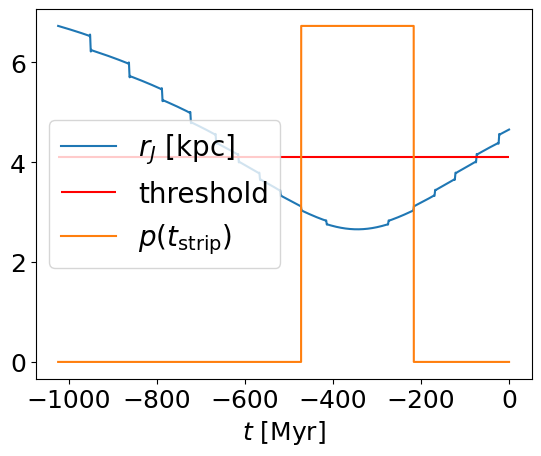

In [103]:
#Need threshold to be input or fixed...
#factor_min_Jacobi_Radius = 1.5
plt.plot(dict_out1['dense_times'],dict_out1['Jacobi_Radius_eval'],label=r'$r_J$ [kpc]')
plt.hlines(dict_out1['Jacobi_Radius_eval'].min()*r_e1,dict_out1['dense_times'].min(),0,label='threshold',color='r')

plt.plot(dict_out1['dense_times'],dict_out1['prob_strip']/(dict_out1['prob_strip'].max())*dict_out1['Jacobi_Radius_eval'].max(),label=r'$p(t_{\rm strip})$')
plt.xlabel(r'$t$ [Myr]',fontsize=18)
plt.legend()

Text(0, 0.5, '$r_{\\rm orb}$ [kpc]')

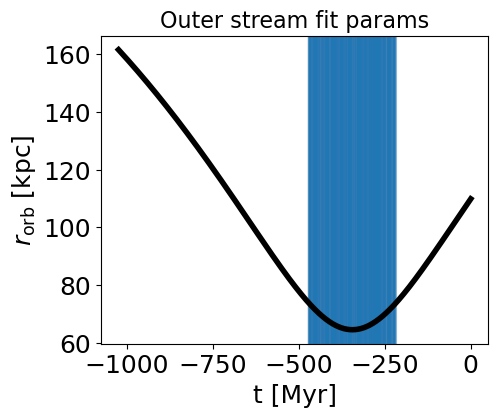

In [106]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(5,4)
ax.plot(prog_orb1.ts, r_orb1,zorder=5,color='k',lw=4,)
for i in range(len(tstrip_stream1)-1):
    ax.axvline(x=tstrip_stream1[i], ymin=0, ymax=1.,color='tab:blue', linestyle='-',alpha=0.1)

plt.title('Outer stream fit params', fontsize=16)
ax.set_xlabel('t [Myr]',fontsize=18)
ax.set_ylabel(r'$r_{\rm orb}$ [kpc]',fontsize=18)
##plt.savefig('r_orb_t_and_strip.pdf')

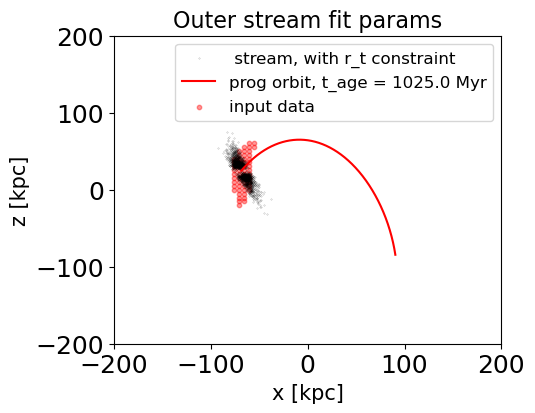

In [105]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(5,4)
ax.scatter(stream1[:,0], stream1[:,2],zorder=5,color='k',s=0.05, alpha=0.4, label=' stream, with r_t constraint')
ax.plot(prog_orb1.ys[:,0], prog_orb1.ys[:,2],zorder=5,color='r', label ='prog orbit, t_age = ' + str(np.round(t_age_fit,0)) +' Myr' )#
plt.xlim([-200,200])
plt.ylim([-200,200])
plt.xlabel('x [kpc]', fontsize=15)
plt.ylabel('z [kpc]', fontsize=15)
plt.title('Outer stream fit params', fontsize=16)
plt.scatter(dat_outer[:,0], dat_outer[:,2], s=10, alpha = 0.4, color='red', label='input data')# , label='[vx, vy_los, vz] =  '+ str(np.round(velocity_today*(u.kpc/u.Myr).to(u.km/u.s),2) )+ ' km/s')
plt.legend(fontsize=12)

## Rest of methods 

In [ ]:
#SP uncommented, since we don't use this in inference loop and it reads in Jake's test strem which we don't have 
def eval_log_pdf(params_constrain, params_fix):
    params_gen_stream = {**params_constrain, **params_fix}
    stream_dict = gen_stream(**params_gen_stream)
    log_pdata = kde_fit_and_log_eval(stream_dict['stream'][:,0],stream_dict['stream'][:,2], dat_outer[:,0],dat_outer[:,1]) #already in x,z coords 
    return log_pdata, stream_dict['stream']



In [ ]:
params_constrain_names = ['y_prog', 'speed', 'vel_theta', 'vel_phi', 'log10_M_prog',
                    'log10_m_halo', 'r_s', 'gamma', 'beta', 't_age']
params_fix_names = ['x_prog','z_prog','log10_m_disk','a_disk','b_disk','N_arm']


constrained_values_truth = {key: jnp.array(outer_stream_prog0[key]) for key in params_constrain_names}
fixed_values_truth =  {key: jnp.array(outer_stream_prog0[key]) for key in params_fix_names}
fixed_values_truth['N_arm'] = 500# 600, 800

# SP uncommented below
log_pdf_master = lambda params_constrain: eval_log_pdf(params_constrain, fixed_values_truth)[0]
log_pdf_master = jax.jit(log_pdf_master)


#out = log_pdf_master(constrained_values_truth)

In [ ]:
constrained_values_truth

In [ ]:
fixed_values_truth

In [ ]:
@jax.jit
def get_prog_coords(params_constrain, params_fix=fixed_values_truth):
    params_tot = {**params_constrain, **fixed_values_truth}
    vel_theta = params_tot['vel_theta']
    vel_phi = params_tot['vel_phi']
    speed = params_tot['speed']
    x_prog = params_tot['x_prog']
    y_prog = params_tot['y_prog']
    z_prog = params_tot['z_prog']
    
    v_x_hat = jnp.sin(vel_theta)*jnp.cos(vel_phi)
    v_y_hat = jnp.cos(vel_theta) #sp swapped below here.
    v_z_hat = jnp.sin(vel_theta)*jnp.sin(vel_phi)
    velocity_today = jnp.array([v_x_hat, v_y_hat, v_z_hat])*speed
    

    pos_today = jnp.array([x_prog, y_prog, z_prog])
    w_today = jnp.hstack([pos_today, velocity_today])
    
    return w_today
    

In [ ]:
@jax.jit
def compute_nrg_prog(w_today, params_pot_constrain):
    pot_params_total = dict(M=10**params_pot_constrain['log10_m_halo'], 
                            r_s=params_pot_constrain['r_s'], 
                            gamma=params_pot_constrain['gamma'],
                            beta=params_pot_constrain['beta'], 
                            m_disk=10**fixed_values_truth['log10_m_disk'], 
                            a_disk=fixed_values_truth['a_disk'], 
                            b_disk=fixed_values_truth['b_disk'])
    pot_curr = get_potential(pot_params_total)
    
    #check if unbound
    nrg_prog = pot_curr.potential(w_today[:3],0.0) + 0.5*jnp.sum(w_today[3:]**2)
    return nrg_prog
    
@jax.jit
def evaluate_cost_no_prior(params_constrain, N_data):
    
    w_today = get_prog_coords(params_constrain)
    nrg = compute_nrg_prog(w_today, params_constrain) 
    bound_bool = nrg < 0.0
    
    def true_func():
        """
        If the progenitor is bound, produce a stream and compute the test-statistic
        """
        log_PDF = log_pdf_master(params_constrain)
        inter_sum = (1./N_data)*( jnp.log((1./N_data)) - log_PDF )
        neg_KL = -jnp.sum(inter_sum)
        neg_KL = jnp.where( jnp.isnan(neg_KL), -jnp.inf, neg_KL)
        return neg_KL ### maximizie this (it's just the evidence lower bound)
    
    def false_func():
        """
        If the progenitor is unbound, return -inf, thereby rejecting the sample
        """
        return -jnp.inf
    
    return jax.lax.cond(bound_bool, true_func, false_func)


### Do something very similar to above but for r_J condition! 




map_dict_names = {key: 0 for key in params_constrain_names}

@jax.jit    
def vectorized_cost(params, N_data):
    mapped_func = jax.vmap(evaluate_cost_no_prior,in_axes=(map_dict_names,None,))
    return mapped_func(params, N_data)


In [ ]:
#evaluate_cost_no_prior(constrained_values_truth,len(dat_outer))

In [ ]:
N_data = len(dat_outer)
bw_red = .1455#.16
# Fit KDE to control points, and evaluate at constrol points [todo, bandwidth optimization?]
log_p_thresh = kde_fit_and_log_eval(dat_outer[:,0],dat_outer[:,1], dat_outer[:,0],dat_outer[:,1],bw=bw_red)
inter_sum_thresh = (1./N_data)*( jnp.log((1./N_data)) - log_p_thresh )
neg_KL_thresh = -jnp.sum(inter_sum_thresh)
print(neg_KL_thresh)
pdf_out_thresh = kde_fit_and_eval(dat_outer[:,0],dat_outer[:,1], x_eval, z_eval, bw=bw_red).reshape(X.shape)

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,5)
ax.pcolormesh(X, Z, pdf_out_thresh)
ax.scatter(dat_outer[:,0],dat_outer[:,1],color='r',s=.5)

ax.set_aspect('equal')



In [ ]:
(.2*u.kpc/u.Myr).to(u.km/u.s)

In [ ]:
from nautilus import Prior
from nautilus import Sampler


prior = Prior()
#prior.add_parameter('y_prog', dist=(-350, 350.))
# prior.add_parameter('y_prog', dist=(-300, 300.))# dist=(-250, 250.))
# prior.add_parameter('speed', dist=(.15, .5))
# prior.add_parameter('vel_theta', dist=( 0, np.pi ))
# prior.add_parameter('vel_phi', dist=(0, 2*np.pi))
# prior.add_parameter('log10_M_prog', dist=( 5., 9.))
# prior.add_parameter('log10_m_halo', dist=( 12.0,13.8))
# prior.add_parameter('r_s', dist=( 10.,30.))
# prior.add_parameter('gamma', dist=( 0.,2.))
# prior.add_parameter('beta', dist=( 2.,4.))
# prior.add_parameter('t_age', dist=( 1_000.,4_500.))

prior.add_parameter('y_prog', dist=(-120.,120.))
prior.add_parameter('speed', dist=(0.05,0.4))#(100.,250.))
prior.add_parameter('vel_theta', dist=(0., jnp.pi))
prior.add_parameter('vel_phi', dist=(0., 2. * jnp.pi))
prior.add_parameter('log10_M_prog', dist=( 7.0,9.5))
prior.add_parameter('log10_m_halo', dist=( 11.0,13.0))
prior.add_parameter('r_s', dist=( 5.,15.))
prior.add_parameter('gamma', dist=( 0.,2.)) #fixed within this range
prior.add_parameter('beta', dist=( 2.,4.)) #fixed within this range
prior.add_parameter('t_age', dist=( 500.,3_500.))




cost_naut = lambda params: vectorized_cost(params, N_data)




In [ ]:
sampler = Sampler(prior, cost_naut, n_live=1000,vectorized=True,n_batch=500) #500, 500
sampler.run(verbose=True, n_eff=15_000,f_live=0.0001)


In [ ]:
# sampler.run(verbose=True, n_eff=15_000,f_live=0.0001)


In [ ]:
# sampler = Sampler(prior, cost_naut, n_live=500,vectorized=True,n_batch=250
                  
                  
#                  )
# sampler.run(verbose=True, n_eff=15_000,f_live=0.0001)


In [ ]:
##sampler.run(verbose=True, n_eff=15_000,f_live=0.0001) #2480


In [ ]:
points, log_w, log_l = sampler.posterior(equal_weight=False)
points.shape, 



In [ ]:
points[-1]

In [ ]:
log_l

In [ ]:
true_params = jnp.array([constrained_values_truth['y_prog'], 
                        constrained_values_truth['speed'],
                        constrained_values_truth['vel_theta'],
                        constrained_values_truth['vel_phi'],
                        constrained_values_truth['log10_M_prog'],
                        constrained_values_truth['log10_m_halo'],
                        constrained_values_truth['r_s'],
                         constrained_values_truth['gamma'],
                         constrained_values_truth['beta'],
                         constrained_values_truth['t_age']
                        ])

true_params.shape

In [ ]:
constrained_values_truth

In [ ]:
#good = ~np.isnan(log_l)
#points = points[good]
#log_l = log_l[good]

In [ ]:
import corner
corner.corner(
    points, weights=np.exp(log_l-log_l.max()), bins=20, labels=prior.keys, color='purple',
    plot_datapoints=False,levels=(0.68,0.95),truths=true_params,
smooth=1.);

In [ ]:
neg_KL_thresh = log_l.max()


In [ ]:
neg_KL_thresh, log_l.max()

In [ ]:

#log_p_thresh = kde_fit_and_log_eval(dat_outer[:,0],dat_outer[:,1], dat_outer[:,0],dat_outer[:,1],bw=bw_red)
#inter_sum_thresh = (1./N_data)*( jnp.log((1./N_data)) - log_p_thresh )
#neg_KL_thresh = -jnp.sum(inter_sum_thresh)
#print(neg_KL_thresh)
#pdf_out_thresh = kde_fit_and_eval(dat_outer[:,0],dat_outer[:,1], x_eval, z_eval, bw=bw_red).reshape(X.shape)


In [ ]:
validity_array = jnp.where(log_l >= neg_KL_thresh*1., 1.0, 0.0)

In [ ]:
#validity_array

In [ ]:
@jax.jit
def Lambda_func(sigma, N):
    return N*( jnp.log(1/sigma) -  0.5*((1./sigma**2)) + 0.5  )


N = len(dat_outer)
thresh = Lambda_func(1.5,N)
vals = -(neg_KL_thresh - log_l)*N
select = vals>thresh 


thresh = Lambda_func(2.,N)
vals = -(neg_KL_thresh - log_l)*N
select2 = vals>thresh 


thresh = Lambda_func(1.4,N)
vals = -(neg_KL_thresh - log_l)*N
select3 = vals>thresh 

In [ ]:
#SP these are empty here.... 

select.sum(), select2.sum(), select3.sum()

In [ ]:


# Create the corner plot
fig = corner.corner(
    points[select2], weights=np.ones(select2.sum()), bins=10, labels=prior.keys, color='purple',
    plot_datapoints=False, levels=(.99,), truths=true_params, smooth=.1, plot_contours=False,
    plot_density=False
      )
axes = np.array(fig.axes).reshape((10, 10))  # Adjust based on the number of features

for i in range(10):
    for j in range(i):
        ax = axes[i, j]

        ax.scatter(points[select2][:, j], points[select2][:, i], color='grey', s=5,rasterized=True
                  )  # Scatter additional points

        ax.scatter(points[select][:, j], points[select][:, i], color='r', s=15,rasterized=True,
                  zorder=3)  # Scatter additional points
        
       

In [ ]:
# sp added from chatgpt
import numpy as np
import scipy.stats as stats
import corner

# Create the corner plot
fig = corner.corner(
    points[select2], weights=np.ones(select2.sum()), bins=10, labels=prior.keys, color='purple',
    plot_datapoints=False, levels=(.99,), truths=true_params, smooth=.1, plot_contours=False,
    plot_density=False
)
axes = np.array(fig.axes).reshape((10, 10))  # Adjust based on the number of features

# Loop over axes to plot scatter and contours
for i in range(10):
    for j in range(i):
        ax = axes[i, j]

        # Scatter points
       # ax.scatter(points[select2][:, j], points[select2][:, i], color='grey', s=5, rasterized=True)
        #ax.scatter(points[select][:, j], points[select][:, i], color='r', s=15, rasterized=True, zorder=3)

        # Compute density estimate for red points
        x = points[select][:, j]
        y = points[select][:, i]
        values = np.vstack([x, y])
        kde = stats.gaussian_kde(values)

        # Define grid for contours
        x_grid = np.linspace(x.min(), x.max(), 100)
        y_grid = np.linspace(y.min(), y.max(), 100)
        X, Y = np.meshgrid(x_grid, y_grid)
        positions = np.vstack([X.ravel(), Y.ravel()])
        Z = kde(positions).reshape(X.shape)

        # Compute 1-sigma level (68% of the points)
        Z_flat = Z.ravel()
        Z_sorted = np.sort(Z_flat)[::-1]  # Sort in descending order
        Z_cumsum = np.cumsum(Z_sorted) / Z_sorted.sum()  # CDF
        sigma_1 = Z_sorted[np.searchsorted(Z_cumsum, 0.68)]  # 1-sigma (68%)
        sigma_2 = Z_sorted[np.searchsorted(Z_cumsum, 0.95)]  # 2-sigma (95%)

        # Plot 1 and 2-sigma contour
        ax.contour(X, Y, Z, levels=[sigma_2, sigma_1], colors=['purple', 'purple'], linewidths=[3.2, 3.2], alpha=[1, 0.4],linestyles=['dashed', 'solid'], zorder=4)

        


## Plot best fit stream

In [ ]:
## Find best fit 

best_idx = np.argmax(log_l)  # Index of the highest log-likelihood
best_params = points[best_idx]

In [ ]:
#change below from countours above 
y_prog_fit = best_params[0]#50 # kpc
speed_fit = best_params[1]# 0.16
vel_theta_fit =best_params[2]# 2.4
vel_phi_fit=best_params[3]#2.5
log10_M_prog_fit= best_params[4]#9
log10_m_halo_fit = best_params[5]
r_s_fit = best_params[6]
gamma_fit =best_params[7]
beta_fit =best_params[8]
t_age_fit = best_params[9]


# y_prog_fit = 50 # kpc
# speed_fit = 0.16
# vel_theta_fit = 1.5
# vel_phi_fit=4.0
# log10_M_prog_fit=8.2
# log10_m_halo_fit = 11.6
# t_age_fit = 1600


In [ ]:
# Check fit from contours
#Choose stream from within countours
# outer_stream_prog1 = dict(x_prog=x_center_outer1,y_prog=y_center_outer3,z_prog=y_center_outer1,speed=0.24,vel_phi=phi_today, vel_theta=theta_today,log10_M_prog=9.0,
#                         log10_m_disk=jnp.log10(5e10), a_disk=3.0,b_disk=0.2,log10_m_halo=11.9,r_s=8.1497,gamma=0.8853,beta=3.674,
#                          t_age=1000., N_arm=4_000) #4_000


# outer_stream_prog1 = dict(x_prog=x_center_outer1,y_prog=y_prog_fit,z_prog=y_center_outer1,speed=speed_fit ,vel_theta=vel_theta_fit,\
#                           vel_phi=vel_phi_fit, log10_M_prog=log10_M_prog_fit,
#                         log10_m_disk=jnp.log10(5e10), a_disk=3.0,b_disk=0.2,log10_m_halo=log10_m_halo_fit,r_s=8.1497,gamma=0.8853,beta=3.2,#3.674,
#                          t_age=t_age_fit, N_arm=4_000) #4_000

outer_stream_prog1 = dict(x_prog=x_center_outer1,y_prog=y_prog_fit,z_prog=y_center_outer1,speed=speed_fit ,vel_theta=vel_theta_fit,\
                          vel_phi=vel_phi_fit, log10_M_prog=log10_M_prog_fit,
                        log10_m_disk=jnp.log10(5e10), a_disk=3.0,b_disk=0.2,log10_m_halo=log10_m_halo_fit,r_s=r_s_fit,gamma=gamma_fit,\
                          beta=beta_fit,#3.674,
                         t_age=t_age_fit, N_arm=4_000) #4_000

# outer_stream_prog0 = dict(x_prog=x_center_outer1,y_prog=y_center_outer3,z_prog=y_center_outer1,speed = 0.1,vel_theta=theta_today,vel_phi=phi_today, log10_M_prog=8.4,
#                         log10_m_disk=jnp.log10(5e10), a_disk=3.0,b_disk=0.2,log10_m_halo=12.879588052300889,r_s=8.1497,gamma=0.8853,beta=3.674,
#                          t_age=2000., N_arm=4_000 )

In [ ]:
#wtoday, outer_stream_NFW, stripping_times =  gen_stream_from_dict(outer_stream_prog1)
outer_stream_dict = gen_stream(**outer_stream_prog1)


In [ ]:
pos_today_fit = np.array([x_center_outer1,y_prog_fit, y_center_outer1  ])

In [ ]:
v_x_hat = jnp.sin(vel_theta_fit)*jnp.cos(vel_phi_fit)
v_y_hat = jnp.cos(vel_theta_fit) #SP moved
v_z_hat = jnp.sin(vel_theta_fit)*jnp.sin(vel_phi_fit)
velocity_today = jnp.array([v_x_hat, v_y_hat, v_z_hat])*speed_fit
velocity_today*(u.kpc/u.Myr).to(u.km/u.s)

In [ ]:
plt.figure(figsize=(7,7))
plt.title('Outer stream fit params', fontsize=16)

plt.scatter(outer_stream_dict['stream'][:,0],outer_stream_dict['stream'][:,2],s=0.006,color='k',label='[x, y_los, z] =  '+ str(np.round(pos_today_fit,2)) + ' kpc')
#plt.scatter(outer_stream_NFW[:,0],outer_stream_NFW[:,2],s=.5)
#plt.hist2d(pos[:,0], pos[:,1], bins=np.linspace(-300,300,800),  cmap = histcolor,norm=LogNorm());
#plt.scatter(x_center_outer1,y_center_outer1, marker='*', s=100, color=color_prog[0], alpha=1, label ='vr = ' + str(np.round(binned_velocities_o1[prog_outer1_index],1)) + ' km/s')
#plt.scatter(dat_inner[:,0], dat_inner[:,1], s=2, alpha = 0.4)
plt.scatter(dat_outer[:,0], dat_outer[:,1], s=10, alpha = 0.4, color='red', \
            label='[vx, vy_los, vz] =  '+ str(np.round(velocity_today*(u.kpc/u.Myr).to(u.km/u.s),2) )+ ' km/s')

plt.xlim([-200,200])
plt.ylim([-200,200])
plt.xlabel('x [kpc]')
plt.legend(fontsize=13)
plt.ylabel('z [kpc]')
#plt.savefig()


#plt.savefig()

In [ ]:
import interpax
@jax.jit
def Lambda_func(sigma, N):
    ## 2D****
    return  N*( jnp.log(1/sigma**2) + 1. - (1/(sigma**2))  )#

#@jax.jit
#def Lambda_func(sigma, N):
    #2d
 #   return N*( jnp.log(1/sigma**2) + 1. - (2.0/sigma**2) )

@jax.jit
def pdf_value_from_sigma(sigma):
    return jnp.exp(-0.5*( (sigma - 1.0 )**2))


sigs = jnp.linspace(1,5,500)
N = len(dat_outer)
theory = Lambda_func(sigs,N)
sig_from_interp = interpax.Interpolator1D(x=jnp.sort(theory), f=sigs[jnp.argsort(theory)], method='cubic2')

plt.plot(sig_from_interp(theory),theory,color='r',ls='-')
plt.plot(sigs,theory,color='k',ls='--')



@jax.jit
def pdf_value_from_TS(TS):
    return pdf_value_from_sigma( sig_from_interp(TS) )
pdf_value_from_TS(-3.)

In [ ]:


N = len(dat_outer)
thresh = Lambda_func(1.3,N)
vals = -(neg_KL_thresh - log_l)*N
select = vals>thresh 


thresh = Lambda_func(2.,N)
vals = -(neg_KL_thresh - log_l)*N
select2 = vals>thresh 


thresh = Lambda_func(1.4,N)
vals = -(neg_KL_thresh - log_l)*N
select3 = vals>thresh 

In [ ]:
select.sum(), select2.sum()

In [ ]:


# Create the corner plot
fig = corner.corner(
    points[select2], weights=np.ones(select2.sum()), bins=10, labels=prior.keys, color='purple',
    plot_datapoints=False, levels=(.99,), truths=true_params, smooth=.1, plot_contours=False,
    plot_density=False
      )
axes = np.array(fig.axes).reshape((10, 10))  # Adjust based on the number of features

for i in range(10):
    for j in range(i):
        ax = axes[i, j]

        ax.scatter(points[select2][:, j], points[select2][:, i], color='grey', s=5,rasterized=True
                  )  # Scatter additional points

        ax.scatter(points[select][:, j], points[select][:, i], color='r', s=15,rasterized=True,
                  zorder=3)  # Scatter additional points
        
       

In [ ]:
one_sig = jnp.exp(-0.5*(1**2))
two_sig = jnp.exp(-0.5*(2**2))

one_sig,two_sig

In [ ]:
np.exp(log_w).sum()

In [ ]:
pdf_vals = pdf_value_from_TS(vals)
pdf_vals = jnp.where(jnp.isnan(pdf_vals),0.0,pdf_vals)
pdf_vals = pdf_vals##/pdf_vals.sum()

#weights = np.exp(log_w)
#idx_choose = np.random.choice(np.arange(len(weights)),size=5000, p=weights)


# Create the corner plot
fig = corner.corner(
    points[:,:], weights=pdf_vals[:], bins=15, labels=prior.keys, color='purple',
    plot_datapoints=False, levels=(.68,.95), truths=true_params, smooth=1.0, plot_contours=True,
      )


In [ ]:
pdf_vals = pdf_value_from_TS(vals)
pdf_vals = jnp.where(jnp.isnan(pdf_vals),0.0,pdf_vals)
#pdf_vals = pdf_vals##/pdf_vals.sum()
#

#points[:,-1], pdf_vals.shape

H = plt.hist(points[:,-2],weights=pdf_vals,bins=50,rasterized=True,density=True);


samps = np.random.choice(points[:,-2],p=pdf_vals/pdf_vals.sum(),size=1000)

plt.hist(samps,density=True,histtype='step',bins=50);
np.quantile(samps,q=[0.16,.84])

In [ ]:
pdf_vals = pdf_value_from_TS(vals)
pdf_vals = jnp.where(jnp.isnan(pdf_vals),0.0,pdf_vals)
#pdf_vals = pdf_vals##/pdf_vals.sum()
#

#points[:,-1], pdf_vals.shape
dim = 0
H = plt.hist(points[:,dim],weights=pdf_vals,bins=50,rasterized=True,density=True);


samps = np.random.choice(points[:,dim],p=pdf_vals/pdf_vals.sum(),size=1000)

plt.hist(samps,density=True,histtype='step',bins=50);
np.quantile(samps,q=[0.16,.84])

In [ ]:
H[0]

In [ ]:
np.sum(pdf_vals_norm>sig_thresh)

In [ ]:
lower_bound, upper_bound

In [ ]:
sig_thresh

In [ ]:


# Create the corner plot
fig = corner.corner(
    points[select2], weights=np.ones(select2.sum()), bins=10, labels=prior.keys, color='purple',
    plot_datapoints=False, levels=(.99,), truths=true_params, smooth=.1, plot_contours=False,
    plot_density=False
      )
axes = np.array(fig.axes).reshape((10, 10))  # Adjust based on the number of features
args = np.argsort(pdf_vals[:])
for i in range(10):
    for j in range(i):
        ax = axes[i, j]

        ax.scatter(points[:][args, j], points[:][args, i], c=pdf_vals[:][args], s=1,
                   cmap='plasma',
                   rasterized=True
                  )  # Scatter additional points

        #ax.scatter(points[select][:, j], points[select][:, i], color='r', s=15,rasterized=True,
         #         zorder=3)  # Scatter additional points
        
       

In [ ]:
wghts = np.exp(log_w)
wghts.sum()

In [ ]:
points.shape

In [ ]:
import interpax
@jax.jit
def Lambda_func(sigma, N):
    return N*( jnp.log(1/sigma) -  0.5*((1./sigma**2)) + 0.5  )

#@jax.jit
#def Lambda_func(sigma, N):
    #2d
 #   return N*( jnp.log(1/sigma**2) + 1. - (2.0/sigma**2) )

@jax.jit
def pdf_value_from_sigma(sigma):
    return jnp.exp(-0.5*(sigma**2))


sigs = jnp.linspace(1,5,500)
N = len(dat_outer)
theory = Lambda_func(sigs,N)
sig_from_interp = interpax.Interpolator1D(x=jnp.sort(theory), f=sigs[jnp.argsort(theory)], method='cubic2')

plt.plot(sig_from_interp(theory),theory,color='r',ls='-')
plt.plot(sigs,theory,color='k',ls='--')



@jax.jit
def pdf_value_from_TS(TS):
    return pdf_value_from_sigma( sig_from_interp(TS) )
pdf_value_from_TS(-3.)

In [ ]:
pdf_vals = pdf_value_from_TS(vals)
pdf_vals = jnp.where(jnp.isnan(pdf_vals),0.0,pdf_vals)
pdf_vals = pdf_vals/pdf_vals.sum()

valid_mask = select




# Create the corner plot
fig = corner.corner(
    points[:], weights=pdf_vals, bins=15, labels=prior.keys, color='purple',
    plot_datapoints=False, levels=(.68,.95), truths=true_params, smooth=.8, plot_contours=True,
      )


In [ ]:


# Create the corner plot
fig = corner.corner(
    points[select2], weights=np.ones(select2.sum()), bins=10, labels=prior.keys, color='purple',
    plot_datapoints=False, levels=(.99,), truths=true_params, smooth=.1, plot_contours=False,
    plot_density=False
      )
axes = np.array(fig.axes).reshape((10, 10))  # Adjust based on the number of features
args = np.argsort(pdf_vals[:])
for i in range(10):
    for j in range(i):
        ax = axes[i, j]

        ax.scatter(points[:][args, j], points[:][args, i], c=pdf_vals[:][args], s=5,
                   cmap='plasma',
                   rasterized=True
                  )  # Scatter additional points

        #ax.scatter(points[select][:, j], points[select][:, i], color='r', s=15,rasterized=True,
         #         zorder=3)  # Scatter additional points
        
       

In [ ]:
np.random.seed(3023)
idx = np.random.choice(np.arange(len(points)), p=pdf_vals, size=8_000)


# Create the corner plot
fig = corner.corner(
    points[idx,:], weights=None, bins=25, labels=prior.keys, color='purple',
    plot_datapoints=False, levels=(.68,.95), truths=true_params, smooth=1, plot_contours=True,
      )


In [ ]:
points.shape

In [ ]:
dist_btween = np.abs((log_l-neg_KL_thresh)/neg_KL_thresh)
validity_array = jnp.where(dist_btween <  .1, 1., 0.0)
validity_array.sum()

In [ ]:
valid_mask = validity_array > 0


# Create the corner plot
fig = corner.corner(
    points[valid_mask], weights=validity_array[valid_mask], bins=10, labels=prior.keys, color='purple',
    plot_datapoints=True, levels=(.99,), truths=true_params, smooth=.1, plot_contours=False,
      )
axes = np.array(fig.axes).reshape((10, 10))  # Adjust based on the number of features

for i in range(3):
    for j in range(i):
        ax = axes[i, j]
        ax.scatter(points[valid_mask][:, j], points[valid_mask][:, i], color='red', s=50)  # Scatter additional points


In [ ]:

# Create the corner plot
corner.corner(
    points, weights=validity_array, bins=10, labels=prior.keys, color='purple',
    plot_datapoints=True, levels=(.99,), truths=true_params, smooth=.1, plot_contours=True,
)

In [ ]:
corner.corner(
    points, weights=validity_array, bins=20, labels=prior.keys, color='purple',
    plot_datapoints=True,levels=(.99,),truths=true_params,
smooth=None);

In [ ]:
neg_KL_thresh*.5